In [ ]:
pip install tensorflow numpy matplotlib kagglehub


In [ ]:
# Install required libraries
!pip install kagglehub tensorflow matplotlib numpy

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
# Download dataset using kagglehub
import kagglehub

# Download latest version of FFHQ dataset
DATASET_PATH = kagglehub.dataset_download("arnaud58/flickrfaceshq-dataset-ffhq")
print(f"Path to dataset files: {DATASET_PATH}")


100%|██████████| 19.5G/19.5G [14:56<00:00, 23.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arnaud58/flickrfaceshq-dataset-ffhq/versions/1


In [ ]:
# Preprocessing utility
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess a single image."""
    image = load_img(image_path, target_size=target_size)  # Resize image
    image = img_to_array(image)  # Convert to array
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Load and preprocess the dataset
def load_dataset(dataset_path, sample_limit=10000):
    """Load and preprocess the entire dataset."""
    # Locate PNG files
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png'):
                image_paths.append(os.path.join(root, file))

    # Limit the number of samples
    image_paths = image_paths[:sample_limit]

    # Preprocess images
    images = np.array([preprocess_image(path) for path in image_paths])
    return images

# Load the dataset
SAMPLE_LIMIT = 10000  # Limit to 10,000 images for faster training
dataset = load_dataset(DATASET_PATH, sample_limit=SAMPLE_LIMIT)
print(f"Loaded dataset shape: {dataset.shape}")


Loaded dataset shape: (10000, 128, 128, 3)


In [ ]:
def build_generator(input_dim):
    """Build the generator model."""
    model = models.Sequential([
        layers.Dense(8 * 8 * 256, input_dim=input_dim),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')
    ])
    return model

generator = build_generator(100)
generator.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 16384)               │       1,654,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 3)         │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,732,611 (10.42 MB)

 Trainable params: 2,732,611 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_discriminator(input_shape):
    """Build the discriminator model."""
    model = models.Sequential([
        layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=input_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=5, strides=2, padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator((128, 128, 3))
discriminator.summary()

# Compile discriminator
discriminator.compile(optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,094,785 (4.18 MB)

 Trainable params: 1,094,785 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_gan(generator, discriminator):
    """Combine generator and discriminator into a GAN."""
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = models.Model(gan_input, gan_output)
    gan.compile(optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    return gan

gan = build_gan(generator, discriminator)
gan.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 128, 128, 3)         │       2,732,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 1)                   │       1,094,785 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,827,396 (14.60 MB)

 Trainable params: 2,732,611 (10.42 MB)

 Non-trainable params: 1,094,785 (4.18 MB)

In [ ]:
# GAN Training function
def train_gan(generator, discriminator, gan, dataset, epochs, batch_size):
    """Train GAN on the dataset."""
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, dataset.shape[0], half_batch)
        real_images = dataset[idx]
        fake_images = generator.predict(np.random.randn(half_batch, 100))

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        g_loss = gan.train_on_batch(np.random.randn(batch_size, 100), np.ones((batch_size, 1)))

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss[0]} | G Loss: {g_loss}")

# Train GAN
EPOCHS = 50
BATCH_SIZE = 16
train_gan(generator, discriminator, gan, dataset, EPOCHS, BATCH_SIZE)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/50 | D Loss: 0.7083046436309814 | G Loss: [array(0.70312274, dtype=float32), array(0.70312274, dtype=float32), array(0.625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


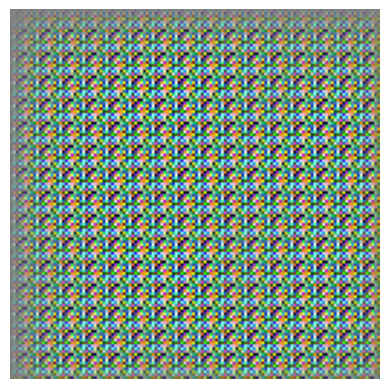

In [ ]:
# Generate and visualize a smiling face
def generate_and_show(generator, seed=None):
    if seed is None:
        seed = np.random.randn(1, 100)
    generated_image = generator.predict(seed)[0]
    plt.imshow((generated_image + 1) / 2)  # Rescale [-1, 1] to [0, 1]
    plt.axis('off')
    plt.show()

generate_and_show(generator)


In [ ]:
# Update hyperparameters for fine-tuning
LEARNING_RATE_GEN = 0.0001  # Lowered learning rate for generator
LEARNING_RATE_DISC = 0.0004  # Slightly higher rate for discriminator
BATCH_SIZE = 16
EPOCHS = 700  # Increased epochs for better training

# Update optimizers
from tensorflow.keras.optimizers import Adam

generator_optimizer = Adam(learning_rate=LEARNING_RATE_GEN, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=LEARNING_RATE_DISC, beta_1=0.5)

# Compile models with updated optimizers
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
gan.compile(optimizer=generator_optimizer, loss='binary_crossentropy')


In [ ]:
# Wasserstein loss for WGAN
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

# Compile discriminator and GAN with Wasserstein loss
discriminator.compile(optimizer=discriminator_optimizer, loss=wasserstein_loss)
gan.compile(optimizer=generator_optimizer, loss=wasserstein_loss)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Augment training dataset
augmented_dataset = datagen.flow(dataset, batch_size=BATCH_SIZE)


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import numpy as np

def calculate_fid(real_images, fake_images):
    # Load InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))

    # Preprocess images for InceptionV3
    real_images = preprocess_input(real_images)
    fake_images = preprocess_input(fake_images)

    # Extract features
    real_features = model.predict(real_images)
    fake_features = model.predict(fake_images)

    # Calculate mean and covariance
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Generate some fake images for FID evaluation
fake_images = generator.predict(np.random.randn(BATCH_SIZE, LATENT_DIM))
real_images = dataset[:BATCH_SIZE]

# Calculate FID
fid_score = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_score}")


NameError: name 'LATENT_DIM' is not defined